In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re

import geopandas as gpd
import requests,json


from shapely import geos
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg,from_string

from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from geopandas import GeoSeries


from shapely import geometry
from shapely.geometry import shape,LineString,Point,Polygon

import osmnx as ox
import networkx as nx

import folium

from folium import IFrame

import seaborn as sns
import branca

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def rest(address):
    try:
        url = 'https://api.tomtom.com/search/2/geocode/{}.json?&key=h2n93GznJsnsDHtv2vPpdT9GmJijp9o9&countrySet=TWN&language=zh-TW&limit=1'.format(address)
        response = requests.get(url)
        data = response.text
        js = json.loads(str(data))
        return js['results'][0]['position']
    except Exception as e:
        print(f'An Error occurred: {e}')
        return {'lat':0,'lon':0}
    
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:3826'})
    return gdf

def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]

heading3 = """<h3>{}</h3>""".format


def overview(gdf_sub,gdf_little_buffer):
    plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
    plt.rcParams["axes.unicode_minus"] = False

    base = gdf_sub.plot(column='行政區',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
    gdf_little_buffer.plot(ax=base,color='gray', markersize=5,alpha=0.5)
    #gdf_little.plot(ax=base, color='green')
    plt.gca().xaxis.set_major_locator(plt.NullLocator()) #去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator()) #去年y轴刻度

In [5]:
gdf=gpd.read_file(r'C:/Users/RT009223/GIS/村里/VILLAGE_MOI_1090423.shp',encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf.crs

<Geographic 2D CRS: EPSG:3824>
Name: TWD97
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Taiwan
- bounds: (114.32, 17.36, 123.61, 26.96)
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:

gdf=trans(gdf)
print(gdf.shape)
gdf=gdf.dropna().reset_index(drop=True)
gdf.COUNTYNAME=list(gdf.COUNTYNAME.apply(lambda x:x.replace('臺','台')))
print(gdf.shape)
gdf.columns=['縣市','行政區','村里','geometry']
gdf.head()


(7965, 4)
(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((184944.359 2488573.475, 184590.382 2..."
1,高雄市,林園區,港埔里,"POLYGON ((185511.383 2488082.466, 185328.939 2..."
2,高雄市,旗津區,上竹里,"POLYGON ((176963.681 2497193.949, 176556.101 2..."
3,高雄市,旗津區,中興里,"POLYGON ((178336.229 2495250.800, 178300.738 2..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((141692.824 2892627.730, 141692.254 2..."


In [7]:
gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

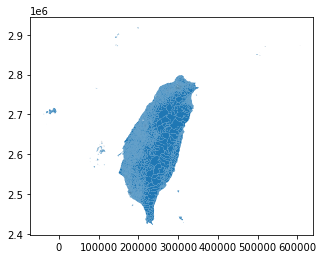

In [52]:
#gdf.plot()

In [8]:
gdf[(gdf['行政區']=='蘆洲區') &(gdf['村里']=='長安里')]

,縣市,行政區,村里,geometry
6981,新北市,蘆洲區,長安里,"POLYGON ((296380.031 2774999.017, 296397.886 2..."


In [8]:
TLW=pd.read_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA店點.xlsx')
geom=[Point(data.lon,data.lat) for idx, data in TLW.iterrows()]
crs = {'init': 'epsg:4326'}
TLW = gpd.GeoDataFrame(TLW, crs=crs, geometry=geom)
TLW=trans(TLW)

In [9]:
gdf.loc[(gdf['行政區']=='蘆洲區') &(gdf['村里']=='長安里'),:]

,縣市,行政區,村里,geometry
6981,新北市,蘆洲區,長安里,"POLYGON ((296380.031 2774999.017, 296397.886 2..."


In [10]:
center=gdf.loc[(gdf['行政區']=='蘆洲區') &(gdf['村里']=='長安里'),:].copy()
gdf_little_buffer=center.loc[:,['geometry']].copy()
center['near']='0'
gdf_little_buffer

radius=float(1)
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

intersection = gpd.overlay(gdf,gdf_little_buffer,  how='intersection')
gdf_sub=gdf[(gdf['行政區']+gdf['村里']).isin(intersection['行政區']+intersection['村里']) ].reset_index(drop=True)

gdf_sub2=gdf_sub[-pd.Series(gdf_sub.geometry).isin(pd.Series(center.geometry))]
gdf_sub2['near']='1'
center=pd.concat([center,gdf_sub2]).reset_index(drop=True).sort_values(by='near')

In [20]:
center=center[center['行政區'].isin(['蘆洲區'])].reset_index(drop=True)
center

,縣市,行政區,村里,geometry,near
0,新北市,蘆洲區,長安里,"POLYGON ((296380.031 2774999.017, 296397.886 2...",0
1,新北市,蘆洲區,延平里,"POLYGON ((296617.950 2774768.519, 296654.760 2...",1
2,新北市,蘆洲區,九芎里,"POLYGON ((296846.863 2774911.485, 296861.617 2...",1
3,新北市,蘆洲區,忠義里,"POLYGON ((296602.926 2775149.597, 296682.456 2...",1
4,新北市,蘆洲區,永德里,"POLYGON ((296423.469 2775239.386, 296444.858 2...",1
5,新北市,蘆洲區,正義里,"POLYGON ((296525.011 2776743.878, 296524.653 2...",2
6,新北市,蘆洲區,中原里,"POLYGON ((297069.506 2775637.586, 297097.851 2...",2
7,新北市,蘆洲區,永康里,"POLYGON ((296354.676 2775351.199, 296381.696 2...",2
8,新北市,蘆洲區,中路里,"POLYGON ((297082.750 2774992.513, 297115.170 2...",2
9,新北市,蘆洲區,永安里,"POLYGON ((296996.170 2774711.672, 297017.137 2...",2


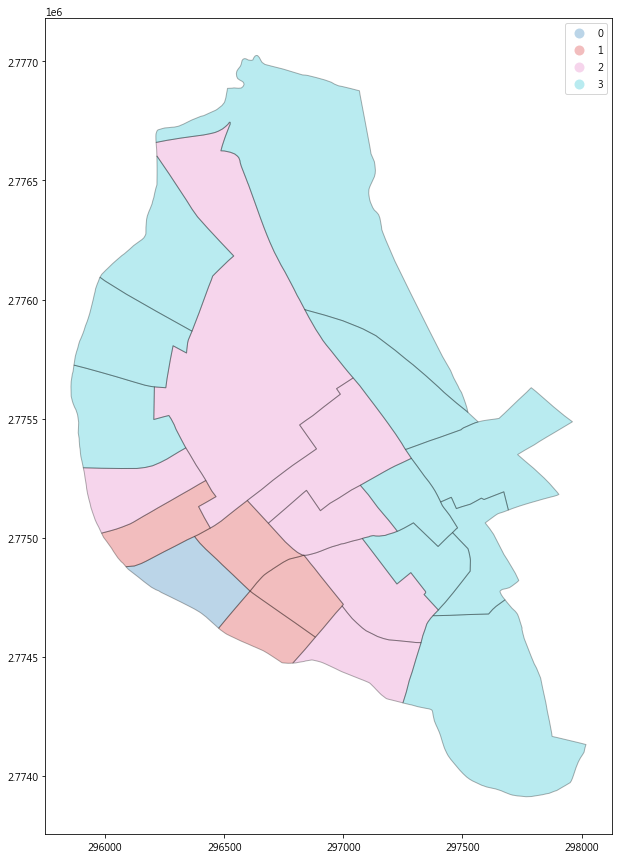

In [21]:
base = center.plot(column='near',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base

In [18]:
lv='3'

gdf_little_buffer=center.loc[:,['geometry']].copy()
#print(gdf_little_buffer)

radius=float(1)
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

intersection = gpd.overlay(gdf,gdf_little_buffer,  how='intersection')
gdf_sub=gdf[(gdf['行政區']+gdf['村里']).isin(intersection['行政區']+intersection['村里']) ].reset_index(drop=True)

gdf_sub2=gdf_sub[-gdf_sub.geometry.isin(center.geometry)]
gdf_sub2['near']=lv
center=pd.concat([center,gdf_sub2]).reset_index(drop=True).sort_values(by='near')

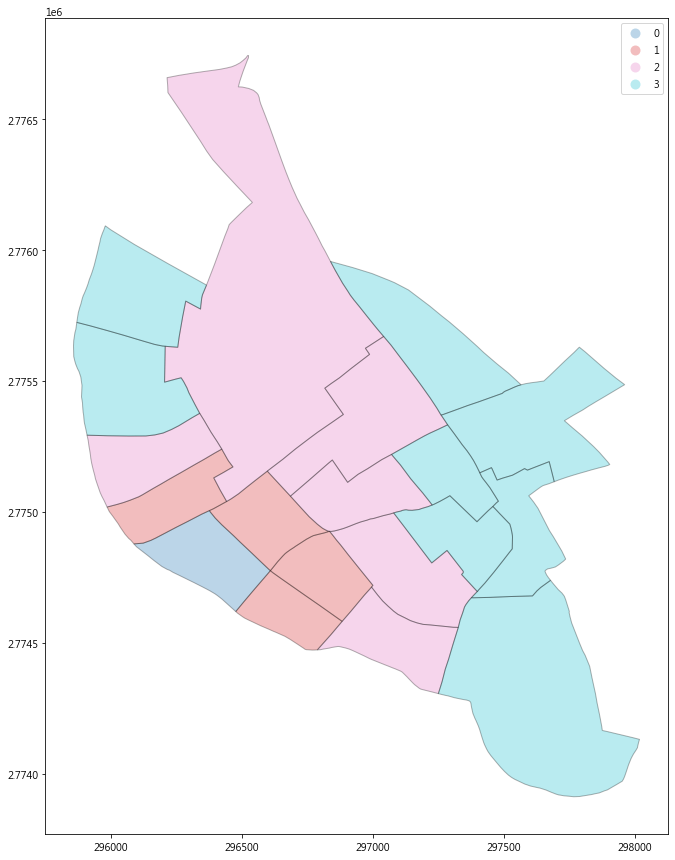

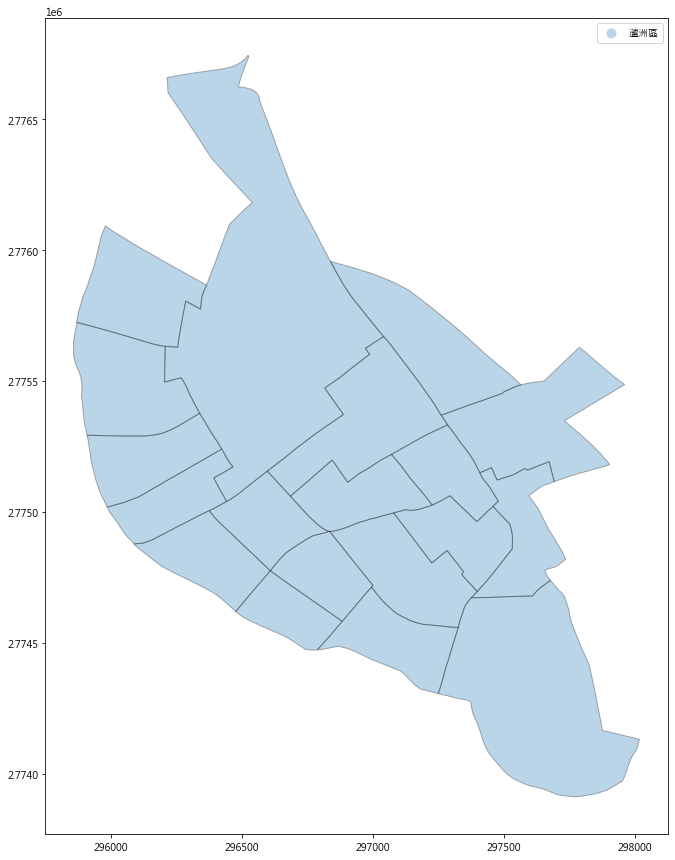

In [29]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
base = center.plot(column='near',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base
base2 = center.plot(column='行政區',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base2

In [24]:
def get_little():
    lon=float(input('請輸入店點經度 : '))
    lat=float(input('請輸入店點緯度 : '))
    geom=[Point(lon,lat)]
    crs = {'init': 'epsg:4326'}
    gdf_little = gpd.GeoDataFrame(pd.DataFrame({'Name':['TLW_little']}), crs=crs, geometry=geom)
    return gdf_little

def trans(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

In [25]:
gdf_little=get_little()
gdf_little=trans(gdf_little)

請輸入店點經度 : 121.461556
請輸入店點緯度 : 25.080756


In [26]:
#25.080756, 121.461556
gdf_little

,Name,geometry
0,TLW_little,POINT (296559.287 2774801.788)


In [27]:
center=center[center.geometry.boundary.distance(gdf_little.geometry[0])<1000].reset_index(drop=True)

In [28]:
center

,縣市,行政區,村里,geometry,near
0,新北市,蘆洲區,長安里,"POLYGON ((296380.031 2774999.017, 296397.886 2...",0
1,新北市,蘆洲區,延平里,"POLYGON ((296617.950 2774768.519, 296654.760 2...",1
2,新北市,蘆洲區,九芎里,"POLYGON ((296846.863 2774911.485, 296861.617 2...",1
3,新北市,蘆洲區,忠義里,"POLYGON ((296602.926 2775149.597, 296682.456 2...",1
4,新北市,蘆洲區,永德里,"POLYGON ((296423.469 2775239.386, 296444.858 2...",1
5,新北市,蘆洲區,正義里,"POLYGON ((296525.011 2776743.878, 296524.653 2...",2
6,新北市,蘆洲區,中原里,"POLYGON ((297069.506 2775637.586, 297097.851 2...",2
7,新北市,蘆洲區,永康里,"POLYGON ((296354.676 2775351.199, 296381.696 2...",2
8,新北市,蘆洲區,中路里,"POLYGON ((297082.750 2774992.513, 297115.170 2...",2
9,新北市,蘆洲區,永安里,"POLYGON ((296996.170 2774711.672, 297017.137 2...",2


In [ ]:
# 22.796807, 120.302761  25.000022, 121.517887  25.055098, 121.488549  25.135305, 121.747104  24.114808, 120.654107

In [ ]:
TLW[TLW.name=='大墩店']

In [24]:
center=center[center.geometry.boundary.distance(TLW.geometry[2])<1500].reset_index(drop=True)

NameError: name 'TLW' is not defined

In [71]:
center=center[center['行政區'].isin(['南區','南屯區','大里區','烏日區'])].reset_index(drop=True)

In [72]:
center

,縣市,行政區,村里,geometry,near
0,台中市,南區,樹義里,"POLYGON ((214841.827 2667964.216, 214908.952 2...",0
1,台中市,南區,工學里,"POLYGON ((215491.215 2667672.217, 215488.216 2...",1
2,台中市,烏日區,五光里,"POLYGON ((215128.381 2666638.804, 215138.808 2...",1
3,台中市,烏日區,前竹里,"POLYGON ((214445.371 2667414.451, 214490.261 2...",1
4,台中市,大里區,樹王里,"POLYGON ((216272.164 2667536.264, 216303.979 2...",1
5,台中市,南區,永興里,"POLYGON ((216149.300 2668011.309, 216281.197 2...",1
6,台中市,烏日區,九德里,"POLYGON ((213771.274 2668282.492, 213778.786 2...",1
7,台中市,南區,樹德里,"POLYGON ((214785.656 2668729.804, 214810.405 2...",1
8,台中市,南屯區,楓樹里,"POLYGON ((212842.737 2668895.962, 212849.587 2...",2
9,台中市,南區,永和里,"POLYGON ((216597.946 2668249.715, 216546.306 2...",2


In [22]:
center.to_excel(r'D:\Users\RT009223\Desktop\1G47.xlsx',index=False)

In [334]:
center.geometry.boundary

0     LINESTRING (217870.516 2652734.750, 217949.984...
1     LINESTRING (217598.766 2652749.000, 217751.812...
2     LINESTRING (218369.766 2652448.750, 218521.984...
3     LINESTRING (218597.594 2652482.500, 218583.188...
4     LINESTRING (217770.797 2652915.750, 217865.922...
5     LINESTRING (216437.172 2654115.750, 216479.641...
6     LINESTRING (218154.531 2653468.750, 218127.531...
7     LINESTRING (220933.109 2653218.500, 220920.656...
8     LINESTRING (217612.831 2650875.355, 217596.761...
9     LINESTRING (218301.125 2653480.000, 218333.328...
10    LINESTRING (219377.949 2651150.905, 219376.596...
11    LINESTRING (220082.141 2655637.749, 220127.530...
12    LINESTRING (215489.969 2654078.000, 215547.250...
13    LINESTRING (218139.906 2650103.250, 218172.312...
14    LINESTRING (216603.906 2652546.500, 216606.346...
15    LINESTRING (216127.897 2650946.570, 216220.657...
16    LINESTRING (223047.844 2654672.750, 223094.828...
17    LINESTRING (217831.269 2656353.401, 218054

In [332]:
center.geometry.boundary.distance(TLW.geometry[15])

0       12.350656
1      205.752941
2      109.260313
3       12.350656
4      366.358390
5      608.486292
6      462.212222
7      446.349986
8      772.369410
9      480.416510
10     613.963728
11     978.771706
12    1588.136937
13    2134.304834
14    1295.724987
15    2024.250747
16    2805.111573
17    1173.827765
18    2557.386611
19    1776.342190
20    1628.220386
21    1494.870782
22    2804.785288
23    2414.974808
24    2873.785840
25    1918.889026
dtype: float64

In [350]:
t1 = Polygon([(10,10), (10,0), (50,50), (20,10)])
t = gpd.GeoSeries(t1)
t.crs = 4326

t2 = gpd.GeoSeries([Point(0,0)])
t2.crs = 4326

In [351]:
dist = t.distance(t2)
print(dist)

0    10.0
dtype: float64


In [352]:
dist = t.boundary.distance(t2)
print(dist)

0    10.0
dtype: float64
